# Setting up environment

Install packages

In [1]:
%pip install --upgrade datasets transformers ninja decord timm accelerate matplotlib
%pip install flash-attn --no-build-isolation


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Using InternVL3 one time

Import packages

In [2]:
import time
import csv
import logging
import math
import torch
import torchvision.transforms as T
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from decord import VideoReader, cpu
from PIL import Image
from torchvision.transforms.functional import InterpolationMode
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer, AutoConfig, CLIPProcessor, CLIPModel
from huggingface_hub import snapshot_download

Split model

In [3]:
def split_model(model_path):
    device_map = {}
    world_size = torch.cuda.device_count()
    config = AutoConfig.from_pretrained(model_path, trust_remote_code=True)
    num_layers = config.llm_config.num_hidden_layers
    # Since the first GPU will be used for ViT, treat it as half a GPU.
    num_layers_per_gpu = math.ceil(num_layers / (world_size - 0.5))
    num_layers_per_gpu = [num_layers_per_gpu] * world_size
    num_layers_per_gpu[0] = math.ceil(num_layers_per_gpu[0] * 0.5)
    layer_cnt = 0
    for i, num_layer in enumerate(num_layers_per_gpu):
        for j in range(num_layer):
            device_map[f'language_model.model.layers.{layer_cnt}'] = i
            layer_cnt += 1
    device_map['vision_model'] = 0
    device_map['mlp1'] = 0
    device_map['language_model.model.tok_embeddings'] = 0
    device_map['language_model.model.embed_tokens'] = 0
    device_map['language_model.output'] = 0
    device_map['language_model.model.norm'] = 0
    device_map['language_model.model.rotary_emb'] = 0
    device_map['language_model.lm_head'] = 0
    device_map[f'language_model.model.layers.{num_layers - 1}'] = 0

    return device_map

Load dataset and model

In [ ]:
dataset = load_dataset("lmms-lab/AISG_Challenge")
snapshot_download("OpenGVLab/InternVL3-78B", local_dir="./InternVL3-78B")
model = AutoModel.from_pretrained(
    "./InternVL3-78B",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=True,
    use_flash_attn=True,
    trust_remote_code=True,
    device_map=split_model('./InternVL3-78B'),
    local_files_only=True).eval()
tokenizer = AutoTokenizer.from_pretrained('./InternVL3-78B', trust_remote_code=True, use_fast=False, local_files_only=True)
generation_config = dict(max_new_tokens=1024, do_sample=False)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)
clip_model = CLIPModel.from_pretrained(
    "openai/clip-vit-base-patch16",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="cuda")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

Fetching 53 files:   0%|          | 0/53 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Download video function

In [5]:
def retrieve_video(video_id):
    filename = f"{video_id}.mp4"
    video_path = f"./videos/videos/{filename}"
    return video_path

Improve prompt

In [6]:
def improve_question(question):
    prompt = f"Generalise the question using only one 5W1H method (Who, What, When, Where, Why, and How). Focus on the main idea of the question instead of specific assumptions. Only return the rewritten question.\nOriginal question: {question}\nRewritten question:"
        
    response, history = model.chat(tokenizer, None, prompt, generation_config, history=None, return_history=True)
    
    return response + " " + question

Narrow down question scope

In [7]:
def narrow(question):
    prompt = f"Break down the question into object, subject, temporal or spatial information in the following format:\nobject, subject, temporal, spatial\nThe question is: {question}."

    response, history = model.chat(tokenizer, None, prompt, generation_config, history=None, return_history=True)
    
    return response

Build transform

In [8]:
def build_transform(input_size):
    MEAN, STD = IMAGENET_MEAN, IMAGENET_STD
    transform = T.Compose([
        T.Lambda(lambda img: img.convert('RGB') if img.mode != 'RGB' else img),
        T.Resize((input_size, input_size), interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(mean=MEAN, std=STD)
    ])
    return transform

Find closest aspect ratio

In [9]:
def find_closest_aspect_ratio(aspect_ratio, target_ratios, width, height, image_size):
    best_ratio_diff = float('inf')
    best_ratio = (1, 1)
    area = width * height
    for ratio in target_ratios:
        target_aspect_ratio = ratio[0] / ratio[1]
        ratio_diff = abs(aspect_ratio - target_aspect_ratio)
        if ratio_diff < best_ratio_diff:
            best_ratio_diff = ratio_diff
            best_ratio = ratio
        elif ratio_diff == best_ratio_diff:
            if area > 0.5 * image_size * image_size * ratio[0] * ratio[1]:
                best_ratio = ratio
    return best_ratio

Dynamic preprocess

In [10]:
def dynamic_preprocess(image, min_num=1, max_num=12, image_size=448, use_thumbnail=False):
    orig_width, orig_height = image.size
    aspect_ratio = orig_width / orig_height

    # calculate the existing image aspect ratio
    target_ratios = set(
        (i, j) for n in range(min_num, max_num + 1) for i in range(1, n + 1) for j in range(1, n + 1) if
        i * j <= max_num and i * j >= min_num)
    target_ratios = sorted(target_ratios, key=lambda x: x[0] * x[1])

    # find the closest aspect ratio to the target
    target_aspect_ratio = find_closest_aspect_ratio(
        aspect_ratio, target_ratios, orig_width, orig_height, image_size)

    # calculate the target width and height
    target_width = image_size * target_aspect_ratio[0]
    target_height = image_size * target_aspect_ratio[1]
    blocks = target_aspect_ratio[0] * target_aspect_ratio[1]

    # resize the image
    resized_img = image.resize((target_width, target_height))
    processed_images = []
    for i in range(blocks):
        box = (
            (i % (target_width // image_size)) * image_size,
            (i // (target_width // image_size)) * image_size,
            ((i % (target_width // image_size)) + 1) * image_size,
            ((i // (target_width // image_size)) + 1) * image_size
        )
        # split the image
        split_img = resized_img.crop(box)
        processed_images.append(split_img)
    assert len(processed_images) == blocks
    if use_thumbnail and len(processed_images) != 1:
        thumbnail_img = image.resize((image_size, image_size))
        processed_images.append(thumbnail_img)
    return processed_images

Load video guided with question

In [11]:
def load_video_question_guided(video_path, question, input_size=448, max_num=1, num_segments=32):
    vr = VideoReader(video_path, ctx=cpu(0), num_threads=1)
    max_frame = len(vr)
    step = int(vr.get_avg_fps())

    if len(range(0, max_frame, step)) >= num_segments:
        sampled_indices = list(range(0, max_frame, step))
    else:
        bins = np.linspace(0, max_frame, num=num_segments+1, dtype=int)
        sampled_indices = [((bins[i] + bins[i + 1]) // 2) for i in range(num_segments)]
    all_images = [Image.fromarray(vr[i].asnumpy()).convert("RGB") for i in sampled_indices]
    
    frame_embeddings = []
    for img in all_images:
        inputs = clip_processor(images=img, return_tensors="pt").to("cuda")
        with torch.no_grad():
            img_feat = clip_model.get_image_features(**inputs)
        frame_embeddings.append(img_feat.squeeze(0))
    frame_embeddings = torch.stack(frame_embeddings)
    frame_embeddings = F.normalize(frame_embeddings, dim=-1)

    text_inputs = clip_processor(text=question, return_tensors="pt").to("cuda")
    with torch.no_grad():
        text_embedding = clip_model.get_text_features(**text_inputs).squeeze(0)
    text_embedding = F.normalize(text_embedding, dim=-1)

    sims = F.cosine_similarity(frame_embeddings, text_embedding.unsqueeze(0))
    top_indices = sorted(sims.topk(num_segments).indices.tolist())
    selected_frames = [all_images[i] for i in top_indices]
    '''
    rows, cols = 8, 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i, ax in enumerate(axes.flat):
        if i < len(selected_frames):
            ax.imshow(selected_frames[i])
            ax.axis('off')
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()
    '''
    pixel_values_list, num_patches_list = [], []
    transform = build_transform(input_size=input_size)
    for img in selected_frames:
        tiles = dynamic_preprocess(img, image_size=input_size, use_thumbnail=True, max_num=max_num)
        pixel_values = [transform(tile) for tile in tiles]
        pixel_values = torch.stack(pixel_values)
        num_patches_list.append(pixel_values.shape[0])
        pixel_values_list.append(pixel_values)
    pixel_values = torch.cat(pixel_values_list)
    return pixel_values, num_patches_list

Process sample

In [12]:
def process_test_case(example):
    video_id = example["video_id"]
    question = example["question"]
    question_prompt = example["question_prompt"]
    
    video_path = retrieve_video(video_id)
    lines = question.split('\n')
    actual_question = next((q for q in lines if q.strip() != ''), None)
    rest_of_question = [line for line in lines if line != actual_question]
    if rest_of_question:
        improved_question = question
    else:
        improved_question = improve_question(actual_question)
    narrowed_scope = narrow(actual_question)

    pixel_values, num_patches_list = load_video_question_guided(video_path, actual_question, num_segments=32, max_num=1)
    pixel_values = pixel_values.to(torch.bfloat16).cuda()
    video_prefix = ''.join([f'Frame{i+1}: <image>\n' for i in range(len(num_patches_list))])

    prompt = video_prefix + f"\nFind the following information from the video:\n{narrowed_scope}"
    response, history = model.chat(tokenizer, pixel_values, prompt, generation_config, num_patches_list=num_patches_list, history=None, return_history=True)
    '''
    print(f"1st Prompt:\n{prompt}")
    print(f"1st Response:\n{response}")
    '''
    prompt = video_prefix + f"\n{improved_question}\n{question_prompt}"
    response, history = model.chat(tokenizer, pixel_values, prompt, generation_config, num_patches_list=num_patches_list, history=history, return_history=True)
    '''
    print(f"2nd Prompt:\n{prompt}")
    print(f"2nd Response:\n{response}")
    print(f"Video URL: {example['youtube_url']}")
    '''
    return example['qid'], response

Run test cases

Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


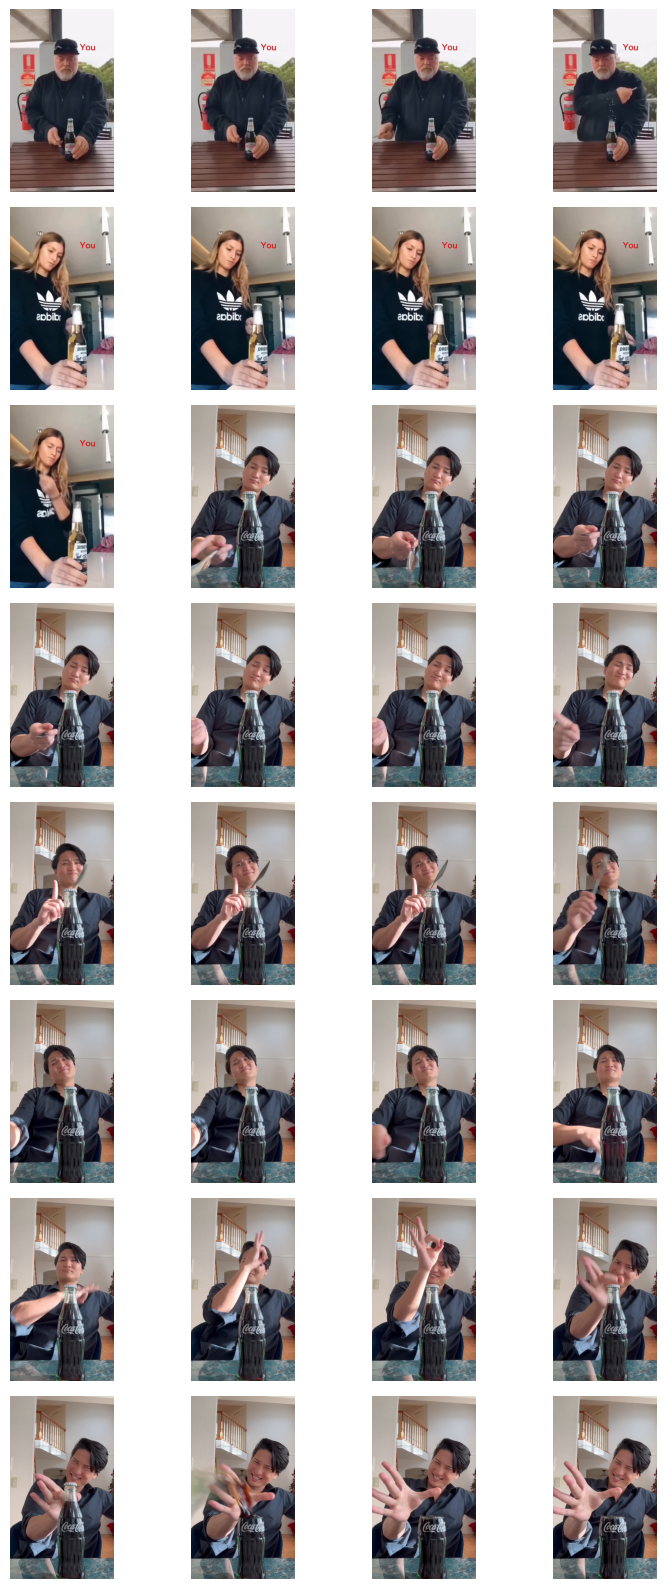

Token indices sequence length is longer than the specified maximum sequence length for this model (8510 > 8192). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


1st Prompt:
Frame1: <image>
Frame2: <image>
Frame3: <image>
Frame4: <image>
Frame5: <image>
Frame6: <image>
Frame7: <image>
Frame8: <image>
Frame9: <image>
Frame10: <image>
Frame11: <image>
Frame12: <image>
Frame13: <image>
Frame14: <image>
Frame15: <image>
Frame16: <image>
Frame17: <image>
Frame18: <image>
Frame19: <image>
Frame20: <image>
Frame21: <image>
Frame22: <image>
Frame23: <image>
Frame24: <image>
Frame25: <image>
Frame26: <image>
Frame27: <image>
Frame28: <image>
Frame29: <image>
Frame30: <image>
Frame31: <image>
Frame32: <image>

Find the following information from the video:
object: action
subject: last person
temporal: last
spatial: video
1st Response:
The last person in the video is sitting at a table with a Coca-Cola bottle in front of them. They are making a hand gesture, possibly indicating a stop or halt. The setting appears to be a home interior with a staircase and a Christmas tree in the background.


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


2nd Prompt:
Frame1: <image>
Frame2: <image>
Frame3: <image>
Frame4: <image>
Frame5: <image>
Frame6: <image>
Frame7: <image>
Frame8: <image>
Frame9: <image>
Frame10: <image>
Frame11: <image>
Frame12: <image>
Frame13: <image>
Frame14: <image>
Frame15: <image>
Frame16: <image>
Frame17: <image>
Frame18: <image>
Frame19: <image>
Frame20: <image>
Frame21: <image>
Frame22: <image>
Frame23: <image>
Frame24: <image>
Frame25: <image>
Frame26: <image>
Frame27: <image>
Frame28: <image>
Frame29: <image>
Frame30: <image>
Frame31: <image>
Frame32: <image>

What are the differences in actions between the last person and the first two people in the video? What is the difference between the action of the last person in the video and the actions of the first two people?
Please state your answer with a brief explanation.
2nd Response:
The first two people in the video are using a spoon to interact with a bottle, likely attempting to open it. The last person, however, is making a hand gesture, possibly ind

In [13]:
start_time = time.time()
output_file = "./results.csv"
start_processing = False
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["qid", "pred"])
    '''
    sample = dataset['test'].filter(lambda x: x['qid'] == '0008-0')[0]
    qid, pred = process_test_case(sample)
    writer.writerow([qid, pred])
    '''
    for sample in dataset['test']:
        if not start_processing:
            if sample['qid'] == "0008-0":
                start_processing = True
            else:
                continue
        logging.debug(f"processing qid {sample['qid']}")
        qid, pred = process_test_case(sample)
        writer.writerow([qid, pred])
    
    end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")